# Multivariate QuasiCopula GWAS with Mixed Marginals

Here we assume each sample have $d$ observations, and we estimate a general covariance matrix 

$$\mathbf{\Gamma} = \mathbf{L}\mathbf{L}^t$$

In [1]:
using Revise
using QuasiCopula
using ToeplitzMatrices
using Distributions
using GLM
using StatsBase

@show Threads.nthreads()

k = 0 # number of causal SNPs]
d = 4 # number of phenotypes
Γ = Matrix(SymmetricToeplitz(0.75.^(0:(d-1))))
σ2true = 0.1

qc_model, G, Btrue, Γtrue, γtrue, τtrue = simulate_multivariate_traits(
    n = 1000, # sample size
    p = 3, # number of fixed effects, including intercept
    d = d, # number of phenotypes
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    Γ = Γ,
    seed = 2024,
    σ2true = σ2true,
    possible_distributions = [Bernoulli, Poisson, Normal],
    use_VC_model=false
);

qc_model.data.Y

Precompiling QuasiCopula
  ✓ QuasiCopula
  1 dependency successfully precompiled in 11 seconds. 164 already precompiled.


Threads.nthreads() = 1


1000×4 Matrix{Float64}:
 1.0   0.395027   0.0  -0.0542791
 0.0   0.702897   4.0   0.49638
 0.0  -0.0850792  0.0  -0.331344
 1.0   1.02708    5.0  -0.871566
 0.0   0.0280367  4.0  -0.230408
 1.0  -0.112102   3.0   0.0297621
 0.0  -0.0820694  0.0   0.112765
 1.0   0.537302   2.0  -0.431652
 1.0  -0.0539401  1.0   0.317129
 1.0   0.210774   2.0  -0.615376
 0.0   0.060039   0.0   0.0121303
 0.0   0.855639   0.0  -0.254774
 0.0   0.594062   0.0  -0.193766
 ⋮                     
 1.0   1.092      3.0   0.069619
 0.0  -0.140436   0.0   0.599763
 1.0   0.709746   0.0   0.307254
 1.0   0.507901   2.0   0.260604
 1.0   0.84272    1.0   0.729014
 1.0   0.813961   0.0  -0.0767162
 0.0   0.51958    1.0  -0.45693
 1.0   0.444777   2.0   0.241009
 0.0   1.20436    2.0   0.00770168
 0.0   0.770633   1.0  -0.173692
 0.0   0.084987   3.0   0.155058
 0.0   0.71693    1.0  -0.430272

In [2]:
@time optm = QuasiCopula.fit!(qc_model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       24
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [3]:
[vec(qc_model.B) vec(Btrue)]

12×2 Matrix{Float64}:
 -0.611478   -0.479976
 -0.568098   -0.185532
 -0.0154747   0.0606237
  0.417384    0.408555
  0.0857606   0.10233
 -0.143483   -0.136129
  0.383318    0.445786
  0.365978    0.33541
  0.191833    0.147032
 -0.0156623  -0.00586126
 -0.236445   -0.226749
  0.0306444   0.0291357

In [4]:
# compare Γ
L = qc_model.L
cov2cor(L.L*L.L')

4×4 Matrix{Float64}:
 1.0       0.74854   0.596163  0.435059
 0.74854   1.0       0.816559  0.57324
 0.596163  0.816559  1.0       0.685076
 0.435059  0.57324   0.685076  1.0

In [5]:
L.L

4×4 LinearAlgebra.LowerTriangular{Float64, Matrix{Float64}}:
 1.11649    ⋅         ⋅         ⋅ 
 0.750489  0.664815   ⋅         ⋅ 
 0.634073  0.593968  0.613495   ⋅ 
 0.428089  0.367393  0.370511  0.716031

In [6]:
cov2cor(Γtrue)

4×4 Matrix{Float64}:
 1.0       0.75    0.5625  0.421875
 0.75      1.0     0.75    0.5625
 0.5625    0.75    1.0     0.75
 0.421875  0.5625  0.75    1.0

In [7]:
# compare nuisance parameters 
[qc_model.ϕ [σ2true for _ in 1:length(qc_model.ϕ)]]

2×2 Matrix{Float64}:
 0.103982   0.1
 0.0944209  0.1

## GWAS via likelihood ratio test on top SNPs

In [ ]:
# gwas
# result = QuasiCopula.multivariateGWAS_adhoc_lrt(qc_model, G)
result = QuasiCopula.multivariateGWAS_adhoc_lrt(qc_model, G, pval_cutoff=1.0)
pvals = result.pvals

# compute power
discovered_snps = findall(x -> x < 0.05/length(pvals), pvals)
causal_snps = unique!([x[1] for x in findall(!iszero, γtrue)])
power = length(discovered_snps ∩ causal_snps) / length(causal_snps)
FP = length(setdiff(discovered_snps, causal_snps))
println("power = $power, FP = $FP")

Estimating grad under null 100%|█████████████████████████| Time: 0:00:44
Running LRT, termination when p > 1.0  82%|███████████▌  |  ETA: 0:24:13

In [ ]:
[pvals sort(pvals)]

Check QQ plot

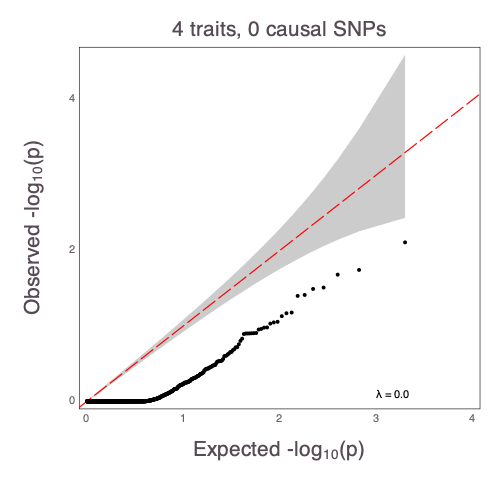

In [15]:
using MendelPlots

# 2 normal, 1 bernoulli, 1 poisson
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

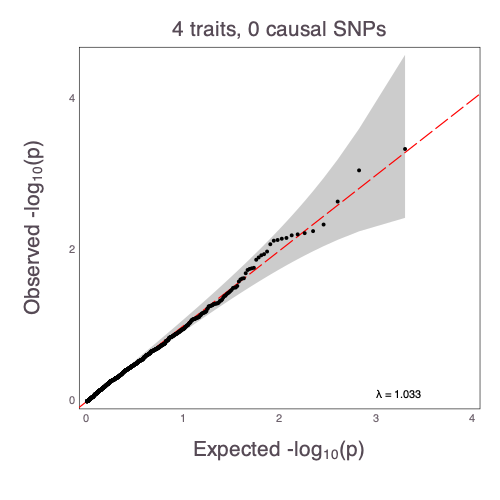

In [32]:
using MendelPlots

# 2 normal, 1 bernoulli, 1 poisson
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

## Fit QuasiCopula model to Gaussian traits

$$y_i \sim N(\mu_i, \Sigma)$$

In [16]:
n = qc_model.data.n
d = qc_model.data.d
X = qc_model.data.X
Gfloat = convert(Matrix{Float64}, G, center=true, scale=true)
Σ = Matrix(SymmetricToeplitz(0.5.^(0:(d-1))))

# sample Gaussian phenotypes
Y = zeros(n, d)
for i in 1:n
    Xi = X[i, :]
    Gi = Gfloat[i, :]
    μi = Btrue' * Xi + γtrue' * Gi
    Y[i, :] .= rand(MvNormal(μi, Σ))
end

# fit QC model
qc_model2 = QuasiCopula.MultivariateCopulaModel(Y, X, [Normal for i in 1:d], [IdentityLink() for i in 1:d])
@time optm = QuasiCopula.fit!(qc_model2);

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       26
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.6762553e+03 0.00e+00 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [17]:
# gwas
result2 = QuasiCopula.multivariateGWAS_adhoc_lrt(qc_model2, G, pval_cutoff=1.0)
pvals = result2.pvals

# compute power
discovered_snps = findall(x -> x < 0.05/length(pvals), pvals)
causal_snps = unique!([x[1] for x in findall(!iszero, γtrue)])
power = length(discovered_snps ∩ causal_snps) / length(causal_snps)
FP = length(setdiff(discovered_snps, causal_snps))
println("(simulate under Gaussian model) power = $power, FP = $FP")

Estimating grad under null 100%|█████████████████████████| Time: 0:00:04
Running LRT, termination when p > 1.0 100%|██████████████| Time: 0:03:06


(simulate under Gaussian model) power = NaN, FP = 2


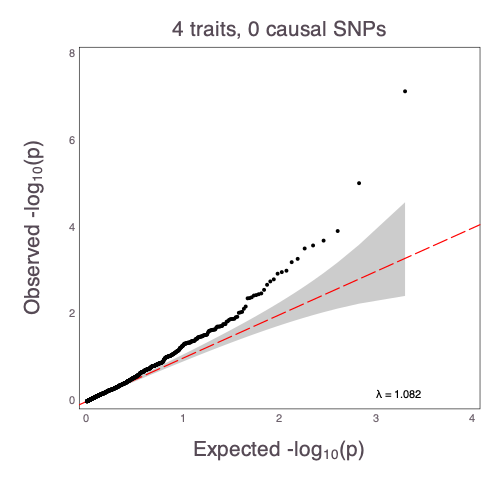

In [18]:
using MendelPlots

# 2 normal, 1 bernoulli, 1 poisson
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [19]:
discovered_snps

2-element Vector{Int64}:
 267
 530

In [20]:
causal_snps

Int64[]